DS 1: Data Analysis, Visualization & Databases
Project 1 Guidelines: Summer Academy NPS Data

Project Timeline
Description & data given: Tuesday, January 30th
Data cleaning check-in: Thursday, February 1st
In-class presentations: Tuesday, February 6th

Project Summary
For your first major project of DS 1, you’ll be investigating real-world data from feedback surveys completed during Make School’s very own Summer Academy program! Completing this project will you’ll strengthen your understanding of:
The overall Data Science process (define, measure, analyze, improve, control)
Aggregating data sets from multiple files, locations, and types
The importance of scripting and automating data preprocessing
Transforming data so that it has the same scale and data type
Best practices for investigating data and asking interesting questions
Data Visualization strategies
Distilling findings down into small, understandable, non-technical (!) presentations

Description of Problem
Clean and investigate Make School NPS data to find interesting and actionable trends that help inform decision-makers. Create a presentation in a Jupyter Notebook using data visualizations and other techniques that allow non-technical team members to understand your findings. 

Background on NPS
Every summer, Make School welcomes hundreds of students into the Summer Academy to study software development and build cool stuff. The management wants to make sure that students continue to be satisfied with their experience as the program scales. The main way we measure this is through Net Promoter Score (NPS), which is a tool commonly used to measure customer loyalty and promotion. You’ve seen NPS before if you’ve been asked a question like:
“On a scale of 1 to 10, how likely are you to recommend [X] to a friend or colleague?”

NPS segments all responses between 1 and 10 into three categories based on their sentiment:
Promoter (9 – 10)
Passive (7 – 8)
Detractor (1 – 6)

To calculate NPS, companies follow these steps:
Segment all responses into Promoter, Passive, and Detractor categories.
Calculate the percentage of responses in each category out of the total number of responses to the survey.
Subtract the Detractors percentage from the Promoters percentage. This is the NPS.

In other words, NPS can be calculated with this equation:
NPS = (Promoters - Detractors)  (Promoters + Passives + Detractors)

NPS can range from –100 (if everyone is a detractor) to +100 (if everyone is a promoter).

For more detailed information on NPS, read this article.

Background on Data Set
Make School’s Summer Academy typically last for 8 weeks, although this can vary by location. Every week, students are given a survey asking their satisfaction with the program in the form of an NPS question (see example question in “Background on NPS” section).

You have been given data from Summer Academy in 2016 and 2017. Download the data here. We will do an initial data investigation during class to get a feel for how the data is structured.

You should create a data dictionary that describes what each column’s possible values mean.

Questions to Consider Answering
In this scenario, you’ve just been given access to this data from your boss, with the instructions to “See if you can find anything in here that can help the business.” – This is a very broad set of instructions.  In order to complete this task well, you may want to consider finding answers to the following questions:
What are things we could find here that could “help the business”?
What sorts of information does this data set contain?
What kinds of questions might we be able to answer with this data?
What kinds of questions can’t we answer with this data?
What sorts of information might be actionable?
How can you present your findings in a way that non-technical employees can understand and use to make decisions?

Data Wrangling Issues to Consider
CSV files may have header rows
Collating data from multiple sources
Introducing new columns/attributes
Converting data types (string values to integers)
Converting categorical values (either to integers or one-hot encoding)
Normalizing values based on different units


In [3]:
# Run this cell to import the packages you'll need
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import csv
%matplotlib inline

In [105]:
# Define the locations of the datasets
nps2017_location = "datasets/SA Feedback Surveys/2017"
nps2017_scores_file = nps2017_location + "/Student Feedback Surveys-Superview.csv"
nps2016_location = "datasets/SA Feedback Surveys/2016/Standard Surveys"

# Define location where cleaned data should be saved
cleaned_file = "datasets/SA Feedback Surveys/2016/cleaned_2016.csv"

# Define location of file we will use to output the merged data of 2016 and 2017
merge_file = "datasets/SA Feedback Surveys/merged_surveys.csv"

# Define the meanings of the city abbreviations in 2016 Dataset for converting to match 2017 dataset
city_abbr_key = {"LA": "Los Angeles", "SF": "San Francisco", "NY": "New York City", "SG": "Singapore", "Singapore": "Singapore", "SV": "Sunnyvale", "HK": "Hong Kong"}

# Define the meanings of the "Schedule Pacing" as integers for better analysis
pacing_conversion_key = {"Way too slow": "1", "A little too slow": "2", "Just right": "3", "A little too fast": "4", "Way too fast": "5"}

# Key for converting "track" from 2016 week 8 data to "track" in 2017 dataset
track_conversion_key = {"summerApps": "Apps", "summerIntro": "\"Apps, Explorer\"", "summerGames": "Games", "summerVR": "VR"}

# Net Promoter Score calculation
def nps_calc(promoters, detractors, total):
    if (total > 0):
        return (promoters - detractors) / total
    else: 
        return 0


In [106]:
# Process the 2016 standard files into the "cleaned_2016.csv" file
def read_and_clean_to_file(read_filenames, write_filename):
    
    write_csv = csv.writer(open(write_filename, 'w', newline=''))
    rows_to_write = []
    
    for filename in read_filenames:
        csv_line = ","
        a, b = filename.find('- '), filename.find('.')
        city = filename[a+2:b]
        if len(city) == 2:
            city = city_abbr_key[city]

        a, b = filename.find('Week '), filename.find(' Feedback -')
        week = filename[a+5:b]


        # Read the file, through each line
        file_reader = csv.reader(open(filename, newline=''), delimiter=",")

        header = next(file_reader) #header

        for row in file_reader:
            row_key = {}
            track = ""
            pacing = ""

            # Generate indices of the different values we are looking for
            for key in header:
                row_key[key] = header.index(key)


            satisfaction = row[row_key["How would you rate your overall satisfaction with the Summer Academy this week?"]]

            # Not all files have the track
            if ("What track are you in?" in row_key.keys()):
                track = row[row_key["What track are you in?"]]

            # Some ask for "schedule" pacing, others for "tutorial" pacing
            if ("How well is the schedule paced?" in row_key.keys()):
                pacing = row[row_key["How well is the schedule paced?"]]
            if ("How well are the tutorials paced?" in row_key.keys()):
                pacing = row[row_key["How well are the tutorials paced?"]]

            # Construct the line for writing to the csv file.
            csv_line = ['', city, track, week, str(int(satisfaction) * 2), pacing, 2016]
            rows_to_write.append(csv_line)
            
    write_csv.writerows(rows_to_write)
        

In [127]:
# Iterate through the files in 2016 to pull out the Week, City, Satisfaction Rating, and Pace Rating
# Format for data: ID, Location, Track, Week, Rating (Num), Pacing 

filenames = []

for filename in glob.iglob(nps2016_location + '/*.csv'):
    filenames.append(filename)
    
read_and_clean_to_file(filenames, cleaned_file)

In [134]:
# Now that we've cleaned the 2016 data, we can combine the 2016 and the 2017 data
fout=open(merge_file,"a")
# 2017 data:
for line in open(nps2017_scores_file):
    match = next((x for x in pacing_conversion_key.keys() if x in line), False)
#     print(match)
    if(match):
        line = line.replace(match, pacing_conversion_key[match])
    if ("Location" in line):
        index = line.find("\n")
        line = line[:index] + ",Year" + line[index:]
    else:
        if ("\n" not in line):
            line += "\n"
        index = line.find("\n")
        line = line[:index] + ",2017" + line[index:]
    if ("Week " in line):
        index = line.find("Week ")
        line = line[:index] + line[index+5:]
    fout.write(line)
# 2016 data (cleaned):
for line in open(cleaned_file):
    fout.write(line)

fout.close()


In [21]:
# Well, now that the data is cleaned and merged, we can do all sorts of fun stuff with it!
makeschool_surveys_df = pd.read_csv(merge_file)

makeschool_surveys_df.describe()

,ID,Week,Rating (Num),Schedule Pacing,Year
count,1450.000000,2376.000000,2376.000000,2376.000000,2376.000000
mean,757.922069,3.510522,8.401515,3.205808,2016.610269
std,430.382155,2.005858,1.507169,0.615026,0.487792
min,8.000000,1.000000,0.000000,1.000000,2016.000000
25%,386.250000,2.000000,8.000000,3.000000,2016.000000
50%,762.500000,3.000000,8.000000,3.000000,2017.000000
75%,1129.750000,5.000000,10.000000,4.000000,2017.000000
max,1499.000000,8.000000,10.000000,5.000000,2017.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1025a5550>]], dtype=object)

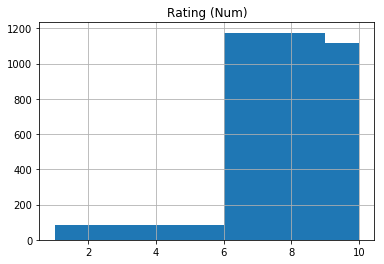

In [174]:
makeschool_surveys_df
makeschool_surveys_df.hist("Rating (Num)", bins=[1, 6, 9, 10], range=[0.0,10.0])

In [29]:
ms_promoters = len(makeschool_surveys_df[makeschool_surveys_df["Rating (Num)"] >= 9])
ms_detractors = len(makeschool_surveys_df[makeschool_surveys_df["Rating (Num)"] <= 6])
ms_total = len(makeschool_surveys_df)

print(nps_calc(ms_promoters, ms_detractors, ms_total))

0.35648148148148145


In [107]:
# Let's compare, for example, total NPS scores across all weeks in 2016 with NPS scores across all weeks in 2017
nps_by_week_2016 = []
nps_by_week_2017 = []

# Gather all of the weekly scores for 2016
for i in range(1, 8):
    weekly_nps_df = makeschool_surveys_df[(makeschool_surveys_df["Week"] == i) & (makeschool_surveys_df["Year"] == 2016)]
    weekly_prom = len(weekly_nps_df[weekly_nps_df["Rating (Num)"] >= 9])
    weekly_dect = len(weekly_nps_df[weekly_nps_df["Rating (Num)"] <= 6])
    weekly_total = len(weekly_nps_df)
    weekly_nps_score = nps_calc(weekly_prom, weekly_dect, weekly_total)
    nps_by_week_2016.append(weekly_nps_score)
    
# Gather all of the weekly scores for 2017
for i in range(1, 9):
    weekly_nps_df = makeschool_surveys_df[(makeschool_surveys_df["Week"] == i) & (makeschool_surveys_df["Year"] == 2017)]
    weekly_prom = len(weekly_nps_df[weekly_nps_df["Rating (Num)"] >= 9])
    weekly_dect = len(weekly_nps_df[weekly_nps_df["Rating (Num)"] <= 6])
    weekly_total = len(weekly_nps_df)
    weekly_nps_score = nps_calc(weekly_prom, weekly_dect, weekly_total)
    nps_by_week_2017.append(weekly_nps_score)

Now that we've gathered all of the NPS Scores by week for 2016 and 2017, we can easily compare them to see how they changed!

NPS is usually plotted on a scale of -100 - 100, so let's see what that looks like!

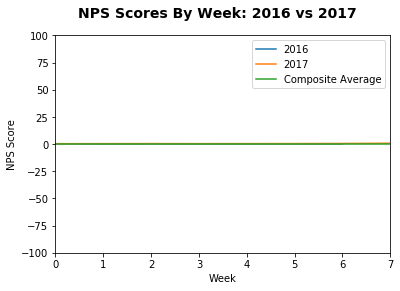

In [108]:
fig = plt.figure()
fig.suptitle('NPS Scores By Week: 2016 vs 2017', fontsize=14, fontweight='bold')

plt.plot(nps_by_week_2016)
plt.plot(nps_by_week_2017)
plt.plot([0.35648148148148145, 0.35648148148148145, 0.35648148148148145, 0.35648148148148145, 0.35648148148148145, 0.35648148148148145, 0.35648148148148145, 0.35648148148148145])
plt.axis([0,7,-100,100])
plt.legend(['2016', '2017', 'Composite Average'])
plt.xlabel("Week")
plt.ylabel("NPS Score")
plt.show()

Well that's not terribly helpful. Nothing seems to have changed! Let's zoom in a bit and see how accurate that is. 

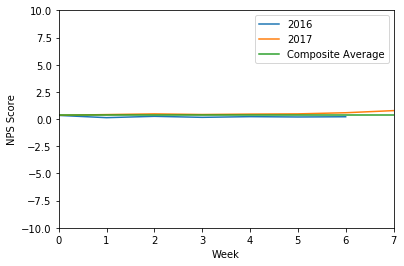

In [109]:
plt.plot(nps_by_week_2016)
plt.plot(nps_by_week_2017)
plt.plot([0.35648148148148145, 0.35648148148148145, 0.35648148148148145, 0.35648148148148145, 0.35648148148148145, 0.35648148148148145, 0.35648148148148145, 0.35648148148148145])
plt.axis([0,7,-10,10])
plt.legend(['2016', '2017', 'Composite Average'])
plt.xlabel("Week")
plt.ylabel("NPS Score")
plt.show()

Well that looks a bit different. 2017 seems like there was some definite improvement, especially as the weeks go on. 

Let's zoom in just a bit further and see how they stack up.

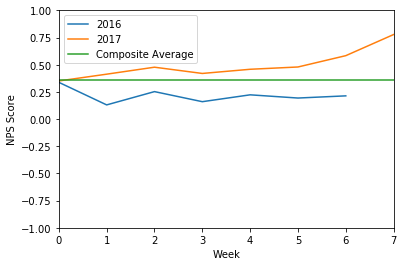

In [110]:
plt.plot(nps_by_week_2016)
plt.plot(nps_by_week_2017)
plt.plot([0.35648148148148145, 0.35648148148148145, 0.35648148148148145, 0.35648148148148145, 0.35648148148148145, 0.35648148148148145, 0.35648148148148145, 0.35648148148148145])
plt.axis([0,7,-1,1])
plt.legend(['2016', '2017', 'Composite Average'])
plt.xlabel("Week")
plt.ylabel("NPS Score")
plt.show()

Wow! At this scale it looks like 2017 was WAY better than 2016. But check out the y-axis. 

The difference between the lowest score in 2016 and the highest score in 2017 is only roughly 0.65 points. This means that while there was definitely an improved NPS score, the actual improvement was pretty marginal, as the scale for NPS is -100 (all detractors) to +100 (all promoters). 

However, when we think about this in terms of percentages, the overall improvement can be viewed as well. 

First, let's see what the average was for each year:

In [111]:
avg_nps_2016 = sum(nps_by_week_2016) / len(nps_by_week_2016)

avg_nps_2017 = sum(nps_by_week_2017) / len(nps_by_week_2017)

print(avg_nps_2016)
print(avg_nps_2017)

print(avg_nps_2017 / avg_nps_2016)

0.21590172482193637
0.4948729751937261
2.2921214529521223


Based on this, our average NPS Score for 2017 was 2.3x higher than in 2016! Incredible!

One anomaly in the data you may have noticed is that there is no NPS score for week 8 in 2016. Why is this? 

Well, the question for Weeks 1-7 in 2016 was "How would you rate your overall satisfaction with the Summer Academy this week?" while the question in Week 8 was changed to "How likely is it that you would recommend the Make School Summer Academy to a friend?" Since these two questions are markedly different, we have opted not to include it in our analysis.

Additionally, the Week 8 survey responses are labeled as "Incomplete", which further brings the value of those results into question.

What other things can this data tell us?

Well, if the NPS Scores improved, what might be the reason? 

Let's see if there is a correlation between NPS Score on Satisfaction with the Summer Academy and NPS Score on Pacing at the Summer Academy:

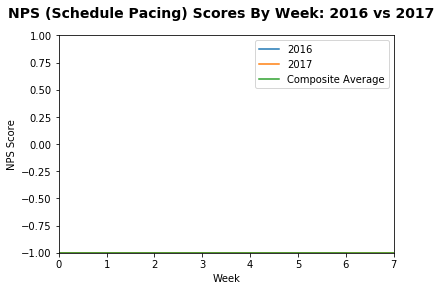

In [112]:
# First, let's gather all of the data we need from 2016 and 2017. Specifically, let's get the "Pacing" scores:
pacing_nps_by_week_2016 = []
pacing_nps_by_week_2017 = []

# Gather all of the weekly scores for 2016
for i in range(1, 8):
    weekly_nps_df = makeschool_surveys_df[(makeschool_surveys_df["Week"] == i) & (makeschool_surveys_df["Year"] == 2016)]
    weekly_prom = len(weekly_nps_df[weekly_nps_df["Schedule Pacing"] >= 9])
    weekly_dect = len(weekly_nps_df[weekly_nps_df["Schedule Pacing"] <= 6])
    weekly_total = len(weekly_nps_df)
    weekly_nps_score = nps_calc(weekly_prom, weekly_dect, weekly_total)
    pacing_nps_by_week_2016.append(weekly_nps_score)
    
# Gather all of the weekly scores for 2017
for i in range(1, 9):
    weekly_nps_df = makeschool_surveys_df[(makeschool_surveys_df["Week"] == i) & (makeschool_surveys_df["Year"] == 2017)]
    weekly_prom = len(weekly_nps_df[weekly_nps_df["Schedule Pacing"] >= 9])
    weekly_dect = len(weekly_nps_df[weekly_nps_df["Schedule Pacing"] <= 6])
    weekly_total = len(weekly_nps_df)
    weekly_nps_score = nps_calc(weekly_prom, weekly_dect, weekly_total)
    pacing_nps_by_week_2017.append(weekly_nps_score)
    
# Then, let's graph that information as well. We already know that the scores are usually pretty close, so let's
# skip ahead a bit and zoom in.
fig = plt.figure()
fig.suptitle('NPS (Schedule Pacing) Scores By Week: 2016 vs 2017', fontsize=14, fontweight='bold')

# Let's calculate the total composite NPS, too, that way we can compare each week of each year to the average of all
ms_pacing_promoters = len(makeschool_surveys_df[makeschool_surveys_df["Schedule Pacing"] >= 9])
ms_pacing_detractors = len(makeschool_surveys_df[makeschool_surveys_df["Schedule Pacing"] <= 6])

avg_pacing_nps = nps_calc(ms_pacing_promoters, ms_pacing_detractors, ms_total)
avg_pacing_series = []

for i in range(1, 9):
    avg_pacing_series.append(avg_pacing_nps)

plt.plot(pacing_nps_by_week_2016)
plt.plot(pacing_nps_by_week_2017)
plt.plot(avg_pacing_series)
plt.axis([0,7,-1,1])
plt.legend(['2016', '2017', 'Composite Average'])
plt.xlabel("Week")
plt.ylabel("NPS Score")
plt.show()

Uh oh! It looks like we don't have any data! What happened?

Well, it looks like our values might be below our bottom value on the y-axis, so let's try adjusting our scale a bit:

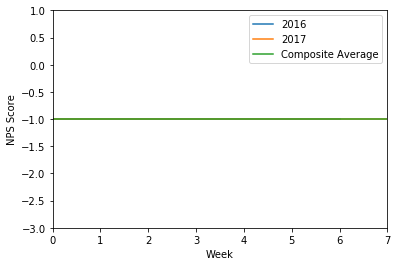

In [113]:
plt.plot(pacing_nps_by_week_2016)
plt.plot(pacing_nps_by_week_2017)
plt.plot(avg_pacing_series)
plt.axis([0,7,-3,1])
plt.legend(['2016', '2017', 'Composite Average'])
plt.xlabel("Week")
plt.ylabel("NPS Score")
plt.show()

Hmmm...Something seems off with our data. What could it be?

Well, it's more likely that something is wrong with the way we processed the data, so let's take a look there to see:

    weekly_nps_df = makeschool_surveys_df[(makeschool_surveys_df["Week"] == i) & (makeschool_surveys_df["Year"] == 2016)]

Can you see where the problem is? 

Well, for "Schedule Pacing" the scale goes from 1-5, rather than from 1-10, with 1 being "way too slow" and 5 being "way too fast". So, for this particular grouping of data, it doesn't make sense to process it the same as normal NPS. 

Instead, let's consider 1 and 5 as detractors, 2 and 4 as neutral, and 3 as a promoter, and try to visualize the data again.



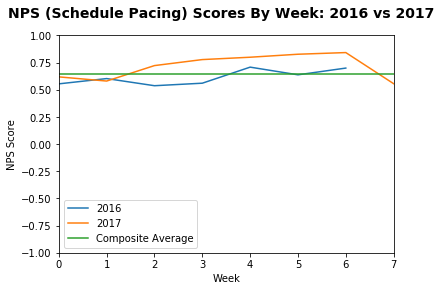

In [114]:
# We have to reprocess the data, because our old data was processed incorrectly. 
pacing_nps_by_week_2016 = []
pacing_nps_by_week_2017 = []

# Gather all of the weekly scores for 2016
for i in range(1, 8):
    weekly_nps_df = makeschool_surveys_df[(makeschool_surveys_df["Week"] == i) & (makeschool_surveys_df["Year"] == 2016)]
    weekly_prom = len(weekly_nps_df[weekly_nps_df["Schedule Pacing"] == 3])
    weekly_dect = len(weekly_nps_df[(weekly_nps_df["Schedule Pacing"] == 1) | (weekly_nps_df["Schedule Pacing"] == 1)])
    weekly_total = len(weekly_nps_df)
    weekly_nps_score = nps_calc(weekly_prom, weekly_dect, weekly_total)
    pacing_nps_by_week_2016.append(weekly_nps_score)
    
# Gather all of the weekly scores for 2017
for i in range(1, 9):
    weekly_nps_df = makeschool_surveys_df[(makeschool_surveys_df["Week"] == i) & (makeschool_surveys_df["Year"] == 2017)]
    weekly_prom = len(weekly_nps_df[weekly_nps_df["Schedule Pacing"] == 3])
    weekly_dect = len(weekly_nps_df[(weekly_nps_df["Schedule Pacing"] == 1) | (weekly_nps_df["Schedule Pacing"] == 1)])
    weekly_total = len(weekly_nps_df)
    weekly_nps_score = nps_calc(weekly_prom, weekly_dect, weekly_total)
    pacing_nps_by_week_2017.append(weekly_nps_score)


# Let's calculate the total composite NPS, too, that way we can compare each week of each year to the average of all
ms_pacing_promoters = len(makeschool_surveys_df[makeschool_surveys_df["Schedule Pacing"] == 3])
ms_pacing_detractors = len(makeschool_surveys_df[(makeschool_surveys_df["Schedule Pacing"] == 1) | (makeschool_surveys_df["Schedule Pacing"] == 5)])

avg_pacing_nps = nps_calc(ms_pacing_promoters, ms_pacing_detractors, ms_total)
avg_pacing_series = []

for i in range(1, 9):
    avg_pacing_series.append(avg_pacing_nps)
    
# Let's try graphing that again.
fig = plt.figure()
fig.suptitle('NPS (Schedule Pacing) Scores By Week: 2016 vs 2017', fontsize=14, fontweight='bold')

plt.plot(pacing_nps_by_week_2016)
plt.plot(pacing_nps_by_week_2017)
plt.plot(avg_pacing_series)
plt.axis([0,7,-1,1])
plt.legend(['2016', '2017', 'Composite Average'])
plt.xlabel("Week")
plt.ylabel("NPS Score")
plt.show()

Wow, now the data is all over the place! 

Before, all of our collected data pointed towards an NPS score of -1, or possibly even lower, but once we processed and analyzed the data correctly, we can clearly see that the overall pacing score is much higher (and positive, which is good!). 

Now, let's take a look at both graphs side-by-side to see if there is a correlation between the two:

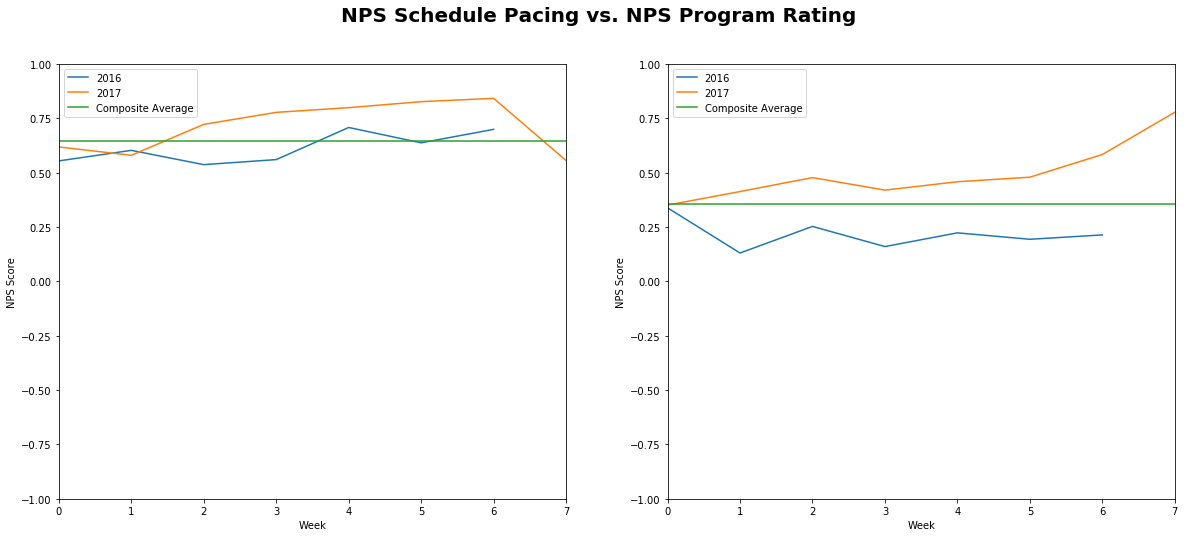

In [115]:
# First, the Pacing NPS scores:
fig = plt.figure(figsize=(20, 8))
fig.suptitle('NPS Schedule Pacing vs. NPS Program Rating', fontsize=20, fontweight='bold')

plt.subplot(1,2,1)
plt.plot(pacing_nps_by_week_2016)
plt.plot(pacing_nps_by_week_2017)
plt.plot(avg_pacing_series)
plt.axis([0,7,-1,1])
plt.legend(['2016', '2017', 'Composite Average'])
plt.xlabel("Week")
plt.ylabel("NPS Score")

plt.subplot(1,2,2)
plt.plot(nps_by_week_2016)
plt.plot(nps_by_week_2017)
plt.plot([0.35648148148148145, 0.35648148148148145, 0.35648148148148145, 0.35648148148148145, 0.35648148148148145, 0.35648148148148145, 0.35648148148148145, 0.35648148148148145])
plt.axis([0,7,-1,1])
plt.legend(['2016', '2017', 'Composite Average'])
plt.xlabel("Week")
plt.ylabel("NPS Score")


plt.show()

So it looks like there *is* a correlation between Schedule Pacing and Program Rating improvements, to a certain degree. Despite the Schedule Pacing rating decreasing heavily in Week 8 of 2017, we still see a marked increase in the Program Rating during this same time. 

Now that we've answered that question, let's try another one:

Is Games Track really best track?

We'll rate tracks based on their individual NPS scores, first as an overall score, and then on a week-by-week basis. 

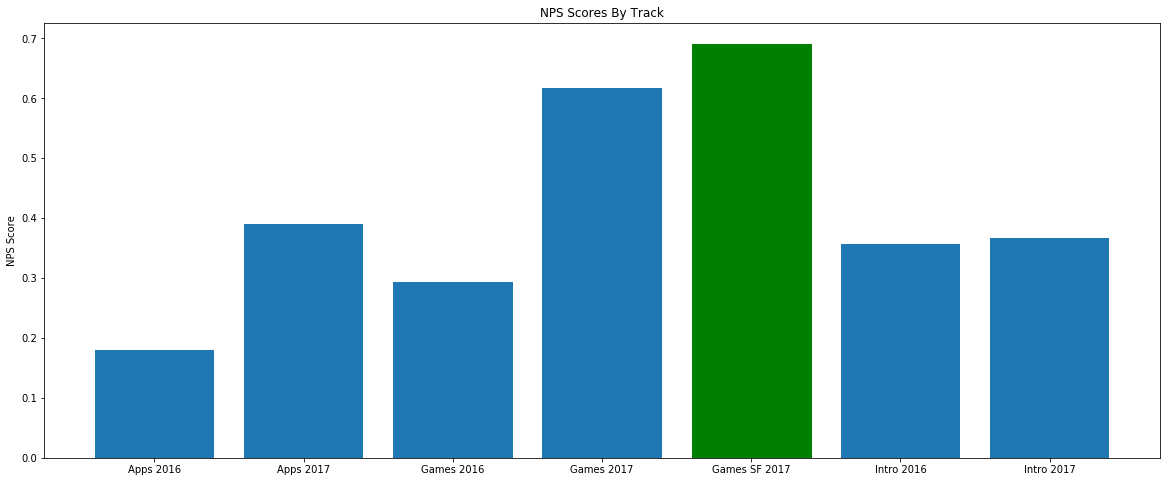

In [116]:
# We're going to have to split this data up a bit more this time. 
games_nps_2016 = []
apps_nps_2016 = []
intro_nps_2016 = []

games_nps_2017 = []
apps_nps_2017 = []
intro_nps_2017 = []

# Let's split the data by track and year first:
games_2016df = makeschool_surveys_df[(makeschool_surveys_df["Track"] == "Games") & (makeschool_surveys_df["Year"] == 2016)]
apps_2016df = makeschool_surveys_df[(makeschool_surveys_df["Track"] == "Apps") & (makeschool_surveys_df["Year"] == 2016)]
intro_2016df = makeschool_surveys_df[(makeschool_surveys_df["Track"] == "Intro") & (makeschool_surveys_df["Year"] == 2016)]

games_2017df = makeschool_surveys_df[((makeschool_surveys_df["Track"] == "Games") | (makeschool_surveys_df["Track"] == "Games, Explorer")) & (makeschool_surveys_df["Year"] == 2017)]
apps_2017df = makeschool_surveys_df[((makeschool_surveys_df["Track"] == "Apps") | (makeschool_surveys_df["Track"] == "Apps, Explorer")) & (makeschool_surveys_df["Year"] == 2017)]
intro_2017df = makeschool_surveys_df[((makeschool_surveys_df["Track"] == "Apps, Explorer") | (makeschool_surveys_df["Track"] == "Games, Explorer")) & (makeschool_surveys_df["Year"] == 2017)]

# Now let's calculate the NPS score of each track
games_2016_promoters = len(games_2016df[games_2016df['Rating (Num)'] >= 9])
games_2016_detractors = len(games_2016df[games_2016df['Rating (Num)'] <= 6])
games_2016_total = len(games_2016df)
games_2016_nps = nps_calc(games_2016_promoters, games_2016_detractors, games_2016_total)

apps_2016_promoters = len(apps_2016df[apps_2016df['Rating (Num)'] >= 9])
apps_2016_detractors = len(apps_2016df[apps_2016df['Rating (Num)'] <= 6])
apps_2016_total = len(apps_2016df)
apps_2016_nps = nps_calc(apps_2016_promoters, apps_2016_detractors, apps_2016_total)

intro_2016_promoters = len(intro_2016df[intro_2016df['Rating (Num)'] >= 9])
intro_2016_detractors = len(intro_2016df[intro_2016df['Rating (Num)'] <= 6])
intro_2016_total = len(intro_2016df)
intro_2016_nps = nps_calc(intro_2016_promoters, intro_2016_detractors, intro_2016_total)

games_2017_promoters = len(games_2017df[games_2017df['Rating (Num)'] >= 9])
games_2017_detractors = len(games_2017df[games_2017df['Rating (Num)'] <= 6])
games_2017_total = len(games_2017df)
games_2017_nps = nps_calc(games_2017_promoters, games_2017_detractors, games_2017_total)

apps_2017_promoters = len(apps_2017df[apps_2017df['Rating (Num)'] >= 9])
apps_2017_detractors = len(apps_2017df[apps_2017df['Rating (Num)'] <= 6])
apps_2017_total = len(apps_2017df)
apps_2017_nps = nps_calc(apps_2017_promoters, apps_2017_detractors, apps_2017_total)

intro_2017_promoters = len(intro_2017df[intro_2017df['Rating (Num)'] >= 9])
intro_2017_detractors = len(intro_2017df[intro_2017df['Rating (Num)'] <= 6])
intro_2017_total = len(intro_2017df)
intro_2017_nps = nps_calc(intro_2017_promoters, intro_2017_detractors, intro_2017_total)

# Wow! That was a lot of work. I wonder if there is a function we could have made to make that easier?
# I bet we could store all the values as an array for easy comparison, even!

# Let's calculate the total composite NPS, too, that way we can compare each week of each year to the average of all
avg_nps = nps_calc(ms_promoters, ms_detractors, ms_total)

# What about Games Track in San Francisco specifically?
games_sf_2017df = games_2017df[games_2017df["Location"] == "San Francisco"]
games_sf_2017_promoters = len(games_sf_2017df[games_sf_2017df['Rating (Num)'] >= 9])
games_sf_2017_detractors = len(games_sf_2017df[games_sf_2017df['Rating (Num)'] <= 6])
games_sf_2017_total = len(games_sf_2017df)
games_sf_2017_nps = nps_calc(games_sf_2017_promoters, games_sf_2017_detractors, games_sf_2017_total)

# Let's store all the scores together first, for easier graphing:
# 2016, 2017
# games, apps, intro
tracks = ["Games 2016", "Apps 2016", "Intro 2016", "Games 2017", "Apps 2017", "Intro 2017", "Games SF 2017"]
nps_scores_by_track = [games_2016_nps, apps_2016_nps, intro_2016_nps, games_2017_nps, apps_2017_nps, intro_2017_nps, games_sf_2017_nps]




# for i in nps_scores_by_track:
#     print(i)

# Now, let's graph all of that.
fig = plt.figure(figsize=(20, 8))
# fig.suptitle('NPS Score by Track and Year', fontsize=14, fontweight='bold')
 
barlist = plt.bar(tracks, nps_scores_by_track)
barlist[6].set_color('g')
plt.ylabel('NPS Score')
plt.title('NPS Scores By Track')
 
plt.show()



Alright, so clearly Games track is best track, as of 2017, but let's dig a little deeper, and see which locations had the best games track.

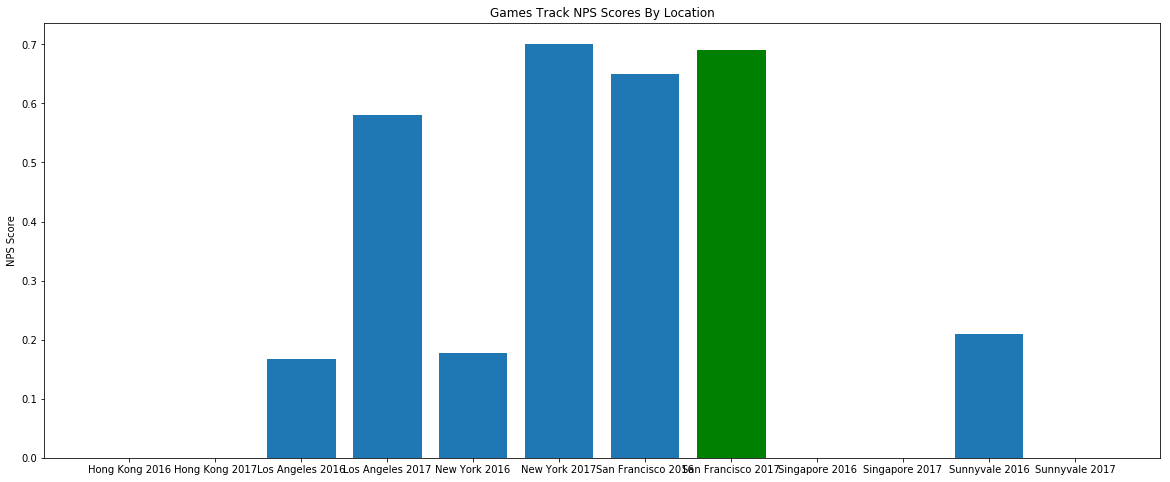

In [128]:
# city_abbr_key = {"LA": "Los Angeles", "SF": "San Francisco", "NY": "New York City", "SG": "Singapore", "Singapore": "Singapore", "SV": "Sunnyvale", "HK": "Hong Kong"}

games_la_2017df = games_2017df[games_2017df["Location"] == "Los Angeles"]
games_la_2017_promoters = len(games_la_2017df[games_la_2017df['Rating (Num)'] >= 9])
games_la_2017_detractors = len(games_la_2017df[games_la_2017df['Rating (Num)'] <= 6])
games_la_2017_total = len(games_la_2017df)
games_la_2017_nps = nps_calc(games_la_2017_promoters, games_la_2017_detractors, games_la_2017_total)

games_ny_2017df = games_2017df[games_2017df["Location"] == "New York City"]
games_ny_2017_promoters = len(games_ny_2017df[games_ny_2017df['Rating (Num)'] >= 9])
games_ny_2017_detractors = len(games_ny_2017df[games_ny_2017df['Rating (Num)'] <= 6])
games_ny_2017_total = len(games_ny_2017df)
games_ny_2017_nps = nps_calc(games_ny_2017_promoters, games_ny_2017_detractors, games_ny_2017_total)

games_sg_2017df = games_2017df[games_2017df["Location"] == "Singapore"]
games_sg_2017_promoters = len(games_sg_2017df[games_sg_2017df['Rating (Num)'] >= 9])
games_sg_2017_detractors = len(games_sg_2017df[games_sg_2017df['Rating (Num)'] <= 6])
games_sg_2017_total = len(games_sg_2017df)
games_sg_2017_nps = nps_calc(games_sg_2017_promoters, games_sg_2017_detractors, games_sg_2017_total)

games_sv_2017df = games_2017df[games_2017df["Location"] == "Sunnyvale"]
games_sv_2017_promoters = len(games_sv_2017df[games_sv_2017df['Rating (Num)'] >= 9])
games_sv_2017_detractors = len(games_sv_2017df[games_sv_2017df['Rating (Num)'] <= 6])
games_sv_2017_total = len(games_sv_2017df)
games_sv_2017_nps = nps_calc(games_sv_2017_promoters, games_sv_2017_detractors, games_sv_2017_total)

games_hk_2017df = games_2017df[games_2017df["Location"] == "Hong Kong"]
games_hk_2017_promoters = len(games_hk_2017df[games_hk_2017df['Rating (Num)'] >= 9])
games_hk_2017_detractors = len(games_hk_2017df[games_hk_2017df['Rating (Num)'] <= 6])
games_hk_2017_total = len(games_hk_2017df)
games_hk_2017_nps = nps_calc(games_hk_2017_promoters, games_hk_2017_detractors, games_hk_2017_total)

games_sf_2016df = games_2016df[games_2016df["Location"] == "San Francisco"]
games_sf_2016_promoters = len(games_sf_2016df[games_sf_2016df['Rating (Num)'] >= 9])
games_sf_2016_detractors = len(games_sf_2016df[games_sf_2016df['Rating (Num)'] <= 6])
games_sf_2016_total = len(games_sf_2016df)
games_sf_2016_nps = nps_calc(games_sf_2016_promoters, games_sf_2016_detractors, games_sf_2016_total)

games_la_2016df = games_2016df[games_2016df["Location"] == "Los Angeles"]
games_la_2016_promoters = len(games_la_2016df[games_la_2016df['Rating (Num)'] >= 9])
games_la_2016_detractors = len(games_la_2016df[games_la_2016df['Rating (Num)'] <= 6])
games_la_2016_total = len(games_la_2016df)
games_la_2016_nps = nps_calc(games_la_2016_promoters, games_la_2016_detractors, games_la_2016_total)

games_ny_2016df = games_2016df[games_2016df["Location"] == "New York City"]
games_ny_2016_promoters = len(games_ny_2016df[games_ny_2016df['Rating (Num)'] >= 9])
games_ny_2016_detractors = len(games_ny_2016df[games_ny_2016df['Rating (Num)'] <= 6])
games_ny_2016_total = len(games_ny_2016df)
games_ny_2016_nps = nps_calc(games_ny_2016_promoters, games_ny_2016_detractors, games_ny_2016_total)

games_sg_2016df = games_2016df[games_2016df["Location"] == "Singapore"]
games_sg_2016_promoters = len(games_sg_2016df[games_sg_2016df['Rating (Num)'] >= 9])
games_sg_2016_detractors = len(games_sg_2016df[games_sg_2016df['Rating (Num)'] <= 6])
games_sg_2016_total = len(games_sg_2016df)
games_sg_2016_nps = nps_calc(games_sg_2016_promoters, games_sg_2016_detractors, games_sg_2016_total)

games_sv_2016df = games_2016df[games_2016df["Location"] == "Sunnyvale"]
games_sv_2016_promoters = len(games_sv_2016df[games_sv_2016df['Rating (Num)'] >= 9])
games_sv_2016_detractors = len(games_sv_2016df[games_sv_2016df['Rating (Num)'] <= 6])
games_sv_2016_total = len(games_sv_2016df)
games_sv_2016_nps = nps_calc(games_sv_2016_promoters, games_sv_2016_detractors, games_sv_2016_total)

games_hk_2016df = games_2016df[games_2016df["Location"] == "Hong Kong"]
games_hk_2016_promoters = len(games_hk_2016df[games_hk_2016df['Rating (Num)'] >= 9])
games_hk_2016_detractors = len(games_hk_2016df[games_hk_2016df['Rating (Num)'] <= 6])
games_hk_2016_total = len(games_hk_2016df)
games_hk_2016_nps = nps_calc(games_hk_2016_promoters, games_hk_2016_detractors, games_hk_2016_total)

locations = ["San Francisco 2017", "Los Angeles 2017", "New York 2017", "Singapore 2017", "Sunnyvale 2017", "Hong Kong 2017", "San Francisco 2016", "Los Angeles 2016", "New York 2016", "Singapore 2016", "Sunnyvale 2016", "Hong Kong 2016"]
nps_scores_by_location = [games_sf_2017_nps, games_la_2017_nps, games_ny_2017_nps, games_sg_2017_nps, games_sv_2017_nps, games_hk_2017_nps, games_sf_2016_nps, games_la_2016_nps, games_ny_2016_nps, games_sg_2016_nps, games_sv_2016_nps, games_hk_2016_nps]


# Now, let's graph all of that.
fig = plt.figure(figsize=(20, 8))
# fig.suptitle('NPS Score by Track and Year', fontsize=14, fontweight='bold')
 
barlist = plt.bar(locations, nps_scores_by_location)
barlist[0].set_color('g')
plt.ylabel('NPS Score')
plt.title('Games Track NPS Scores By Location')
 
plt.show()


Well, it looks like there were only 2 games tracks in 2017.

And it looks like San Francisco is the winner!

0
0


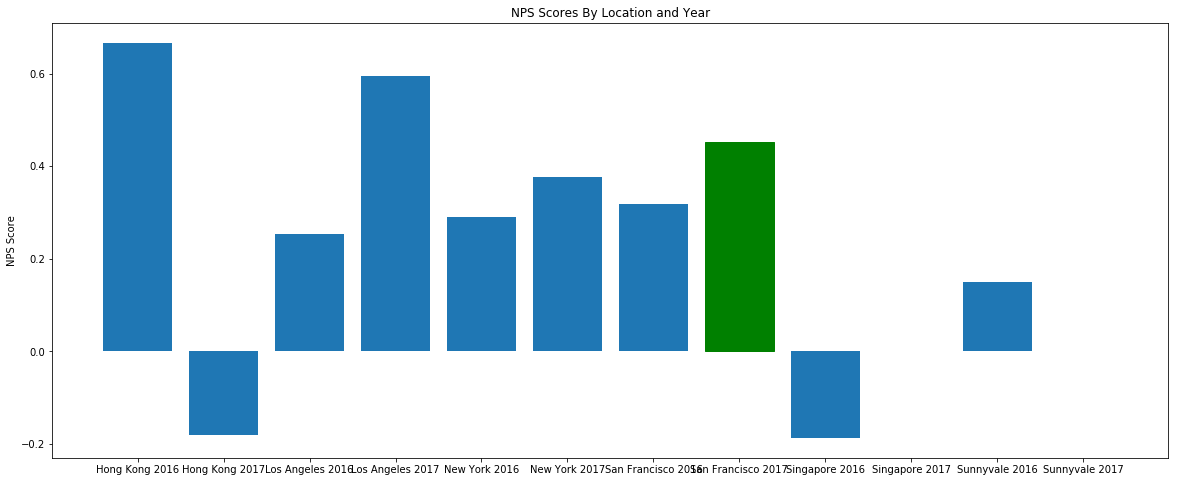

In [130]:
sf_2017df = makeschool_surveys_df[(makeschool_surveys_df["Location"] == "San Francisco") & (makeschool_surveys_df["Year"] == 2017)]
sf_2017_promoters = len(sf_2017df[sf_2017df['Rating (Num)'] >= 9])
sf_2017_detractors = len(sf_2017df[sf_2017df['Rating (Num)'] <= 6])
sf_2017_total = len(sf_2017df)
sf_2017_nps = nps_calc(sf_2017_promoters, sf_2017_detractors, sf_2017_total)

la_2017df = makeschool_surveys_df[(makeschool_surveys_df["Location"] == "Los Angeles") & (makeschool_surveys_df["Year"] == 2017)]
la_2017_promoters = len(la_2017df[la_2017df['Rating (Num)'] >= 9])
la_2017_detractors = len(la_2017df[la_2017df['Rating (Num)'] <= 6])
la_2017_total = len(la_2017df)
la_2017_nps = nps_calc(la_2017_promoters, la_2017_detractors, la_2017_total)

ny_2017df = makeschool_surveys_df[(makeschool_surveys_df["Location"] == "New York City") & (makeschool_surveys_df["Year"] == 2017)]
ny_2017_promoters = len(ny_2017df[ny_2017df['Rating (Num)'] >= 9])
ny_2017_detractors = len(ny_2017df[ny_2017df['Rating (Num)'] <= 6])
ny_2017_total = len(ny_2017df)
ny_2017_nps = nps_calc(ny_2017_promoters, ny_2017_detractors, ny_2017_total)

sg_2017df = makeschool_surveys_df[(makeschool_surveys_df["Location"] == "Singapore") & (makeschool_surveys_df["Year"] == 2017)]
sg_2017_promoters = len(sg_2017df[sg_2017df['Rating (Num)'] >= 9])
sg_2017_detractors = len(sg_2017df[sg_2017df['Rating (Num)'] <= 6])
sg_2017_total = len(sg_2017df)
sg_2017_nps = nps_calc(sg_2017_promoters, sg_2017_detractors, sg_2017_total)

sv_2017df = makeschool_surveys_df[(makeschool_surveys_df["Location"] == "Sunnyvale") & (makeschool_surveys_df["Year"] == 2017)]
sv_2017_promoters = len(sv_2017df[sv_2017df['Rating (Num)'] >= 9])
sv_2017_detractors = len(sv_2017df[sv_2017df['Rating (Num)'] <= 6])
sv_2017_total = len(sv_2017df)
sv_2017_nps = nps_calc(sv_2017_promoters, sv_2017_detractors, sv_2017_total)

hk_2017df = makeschool_surveys_df[(makeschool_surveys_df["Location"] == "Hong Kong") & (makeschool_surveys_df["Year"] == 2017)]
hk_2017_promoters = len(hk_2017df[hk_2017df['Rating (Num)'] >= 9])
hk_2017_detractors = len(hk_2017df[hk_2017df['Rating (Num)'] <= 6])
hk_2017_total = len(hk_2017df)
hk_2017_nps = nps_calc(hk_2017_promoters, hk_2017_detractors, hk_2017_total)

sf_2016df = makeschool_surveys_df[(makeschool_surveys_df["Location"] == "San Francisco") & (makeschool_surveys_df["Year"] == 2016)]
sf_2016_promoters = len(sf_2016df[sf_2016df['Rating (Num)'] >= 9])
sf_2016_detractors = len(sf_2016df[sf_2016df['Rating (Num)'] <= 6])
sf_2016_total = len(sf_2016df)
sf_2016_nps = nps_calc(sf_2016_promoters, sf_2016_detractors, sf_2016_total)

la_2016df = makeschool_surveys_df[(makeschool_surveys_df["Location"] == "Los Angeles") & (makeschool_surveys_df["Year"] == 2016)]
la_2016_promoters = len(la_2016df[la_2016df['Rating (Num)'] >= 9])
la_2016_detractors = len(la_2016df[la_2016df['Rating (Num)'] <= 6])
la_2016_total = len(la_2016df)
la_2016_nps = nps_calc(la_2016_promoters, la_2016_detractors, la_2016_total)

ny_2016df = makeschool_surveys_df[(makeschool_surveys_df["Location"] == "New York City") & (makeschool_surveys_df["Year"] == 2016)]
ny_2016_promoters = len(ny_2016df[ny_2016df['Rating (Num)'] >= 9])
ny_2016_detractors = len(ny_2016df[ny_2016df['Rating (Num)'] <= 6])
ny_2016_total = len(ny_2016df)
ny_2016_nps = nps_calc(ny_2016_promoters, ny_2016_detractors, ny_2016_total)

sg_2016df = makeschool_surveys_df[(makeschool_surveys_df["Location"] == "Singapore") & (makeschool_surveys_df["Year"] == 2016)]
sg_2016_promoters = len(sg_2016df[sg_2016df['Rating (Num)'] >= 9])
sg_2016_detractors = len(sg_2016df[sg_2016df['Rating (Num)'] <= 6])
sg_2016_total = len(sg_2016df)
sg_2016_nps = nps_calc(sg_2016_promoters, sg_2016_detractors, sg_2016_total)

sv_2016df = makeschool_surveys_df[(makeschool_surveys_df["Location"] == "Sunnyvale") & (makeschool_surveys_df["Year"] == 2016)]
sv_2016_promoters = len(sv_2016df[sv_2016df['Rating (Num)'] >= 9])
sv_2016_detractors = len(sv_2016df[sv_2016df['Rating (Num)'] <= 6])
sv_2016_total = len(sv_2016df)
sv_2016_nps = nps_calc(sv_2016_promoters, sv_2016_detractors, sv_2016_total)

hk_2016df = makeschool_surveys_df[(makeschool_surveys_df["Location"] == "Hong Kong") & (makeschool_surveys_df["Year"] == 2016)]
hk_2016_promoters = len(hk_2016df[hk_2016df['Rating (Num)'] >= 9])
hk_2016_detractors = len(hk_2016df[hk_2016df['Rating (Num)'] <= 6])
hk_2016_total = len(hk_2016df)
hk_2016_nps = nps_calc(hk_2016_promoters, hk_2016_detractors, hk_2016_total)

locations = ["San Francisco 2017", "Los Angeles 2017", "New York 2017", "Singapore 2017", "Sunnyvale 2017", "Hong Kong 2017", "San Francisco 2016", "Los Angeles 2016", "New York 2016", "Singapore 2016", "Sunnyvale 2016", "Hong Kong 2016"]
nps_scores_by_location = [sf_2017_nps, la_2017_nps, ny_2017_nps, sg_2017_nps, sv_2017_nps, hk_2017_nps, sf_2016_nps, la_2016_nps, ny_2016_nps, sg_2016_nps, sv_2016_nps, hk_2016_nps]


# Now, let's graph all of that.
fig = plt.figure(figsize=(20, 8))
# fig.suptitle('NPS Score by Track and Year', fontsize=14, fontweight='bold')
 
barlist = plt.bar(locations, nps_scores_by_location)
barlist[0].set_color('g')
plt.ylabel('NPS Score')
plt.title('NPS Scores By Location and Year')
 
plt.show()

Cities:

San Francisco
Los Angeles
New York City
Redwood City
Santa Clara
Washington DC
Chicago
Oakland
Atlanta
Hong Kong
Beijing
Tokyo
Sunnyvale
Taipei


Tracks:
Apps
Games
VR
Intro


In [167]:
cities = ["San Francisco", "Los Angeles", "New York City", "Redwood City", "Santa Clara", "Washington DC", "Chicago", "Oakland", "Atlanta", "Hong Kong", "Beijing", "Tokyo", "Sunnyvale", "Taipei"]

tracks = ["Apps", "Games", "VR", "Intro"]

years = [2016, 2017]

nps_scores = {}

# This version combines "Apps, Explorer" with "Apps", and "Games, Explorer" with "Games
# It also double-uses those scores as "Intro"
def nps_by_city_track_and_year(city, track, year):
    current_df = ""
    if(track == "Apps"):
        current_df = makeschool_surveys_df[(makeschool_surveys_df["Location"] == city) & (makeschool_surveys_df["Year"] == year) & ((makeschool_surveys_df["Track"] == track) | (makeschool_surveys_df["Track"] == "Apps, Explorer"))]
    elif(track == "Games"):
        current_df = makeschool_surveys_df[(makeschool_surveys_df["Location"] == city) & (makeschool_surveys_df["Year"] == year) & ((makeschool_surveys_df["Track"] == track) | (makeschool_surveys_df["Track"] == "Games, Explorer"))]
    elif(track == "Intro"):
        current_df = makeschool_surveys_df[(makeschool_surveys_df["Location"] == city) & (makeschool_surveys_df["Year"] == year) & ((makeschool_surveys_df["Track"] == track) | (makeschool_surveys_df["Track"] == "Apps, Explorer") | (makeschool_surveys_df["Track"] == "Games, Explorer"))]
    else:
        current_df = makeschool_surveys_df[(makeschool_surveys_df["Location"] == city) & (makeschool_surveys_df["Year"] == year) & (makeschool_surveys_df["Track"] == track)]
    current_promoters = len(current_df[current_df['Rating (Num)'] >= 9])
    current_detractors = len(current_df[current_df['Rating (Num)'] <= 6])
    current_total = len(current_df)
    if (current_total == 0):
        return None
    else:
        current_nps = nps_calc(current_promoters, current_detractors, current_total)
        return current_nps

    
# This version lumps Explorers into Intro, but does not count them for their related track.
def alt_nps_by_city_track_and_year(city, track, year):
    current_df = ""
    if(track == "Intro"):
        current_df = makeschool_surveys_df[(makeschool_surveys_df["Location"] == city) & (makeschool_surveys_df["Year"] == year) & ((makeschool_surveys_df["Track"] == track) | (makeschool_surveys_df["Track"] == "Apps, Explorer") | (makeschool_surveys_df["Track"] == "Games, Explorer"))]
    else:
        current_df = makeschool_surveys_df[(makeschool_surveys_df["Location"] == city) & (makeschool_surveys_df["Year"] == year) & (makeschool_surveys_df["Track"] == track)]
    current_promoters = len(current_df[current_df['Rating (Num)'] >= 9])
    current_detractors = len(current_df[current_df['Rating (Num)'] <= 6])
    current_total = len(current_df)
    if (current_total == 0):
        return None
    else:
        current_nps = nps_calc(current_promoters, current_detractors, current_total)
        return current_nps




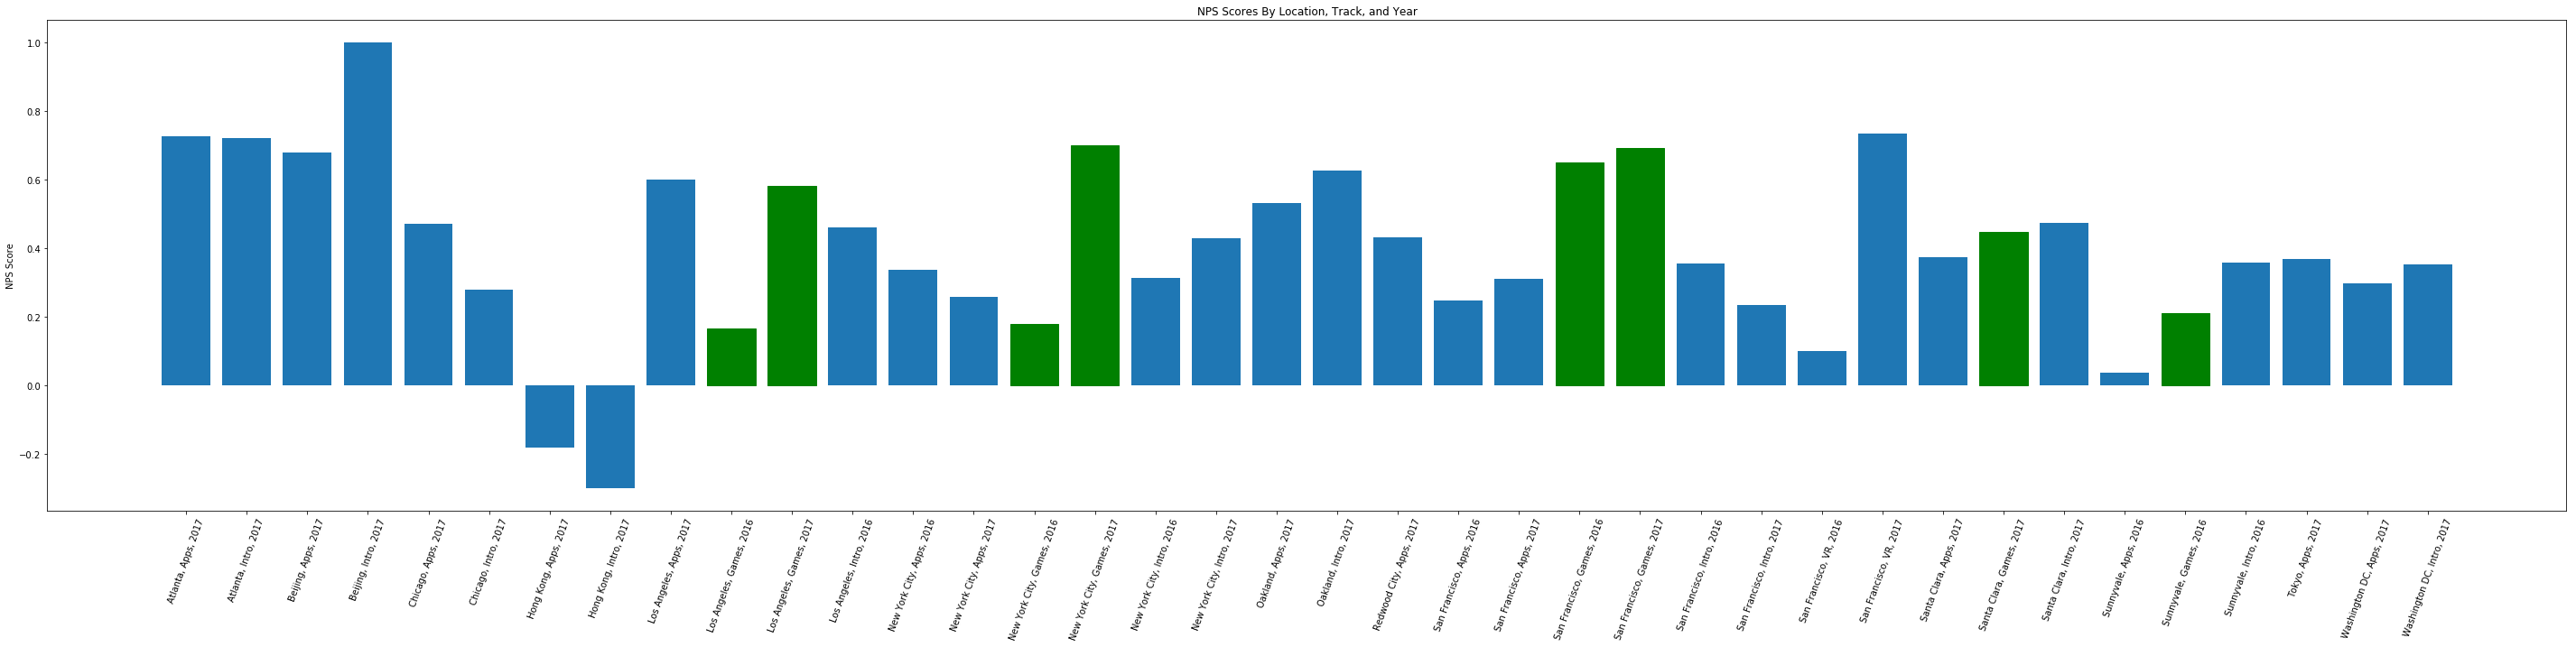

In [172]:
for city in cities:
    for track in tracks:
        for year in years:
            nps = nps_by_city_track_and_year(city, track, year)
            nps_scores[(city, track, year)] = nps
            
# print(nps_scores)

# nps_list = sorted(nps_scores)
# print(nps_list)

y_values = []
x_values = []
games_indeces = []
for item in nps_scores.keys():
    if (nps_scores[item] == None):
        continue
    else:
        label = str(item[0]) + ", " + str(item[1]) + ", " + str(item[2])
        y_values.append(label)
        if(item[1] == "Games"):
            games_indeces.append(y_values.index(label))
        x_values.append(nps_scores[item])


# Now, let's graph all of that.
fig = plt.figure(figsize=(50, 10))
# fig.suptitle('NPS Score by Track and Year', fontsize=14, fontweight='bold')
 
barlist = plt.bar(y_values, x_values)
for index in games_indeces:
    barlist[index].set_color('g')
plt.xticks(rotation=70)
plt.ylabel('NPS Score')
plt.title('NPS Scores By Location, Track, and Year')

plt.savefig("nps.png")
 
plt.show()

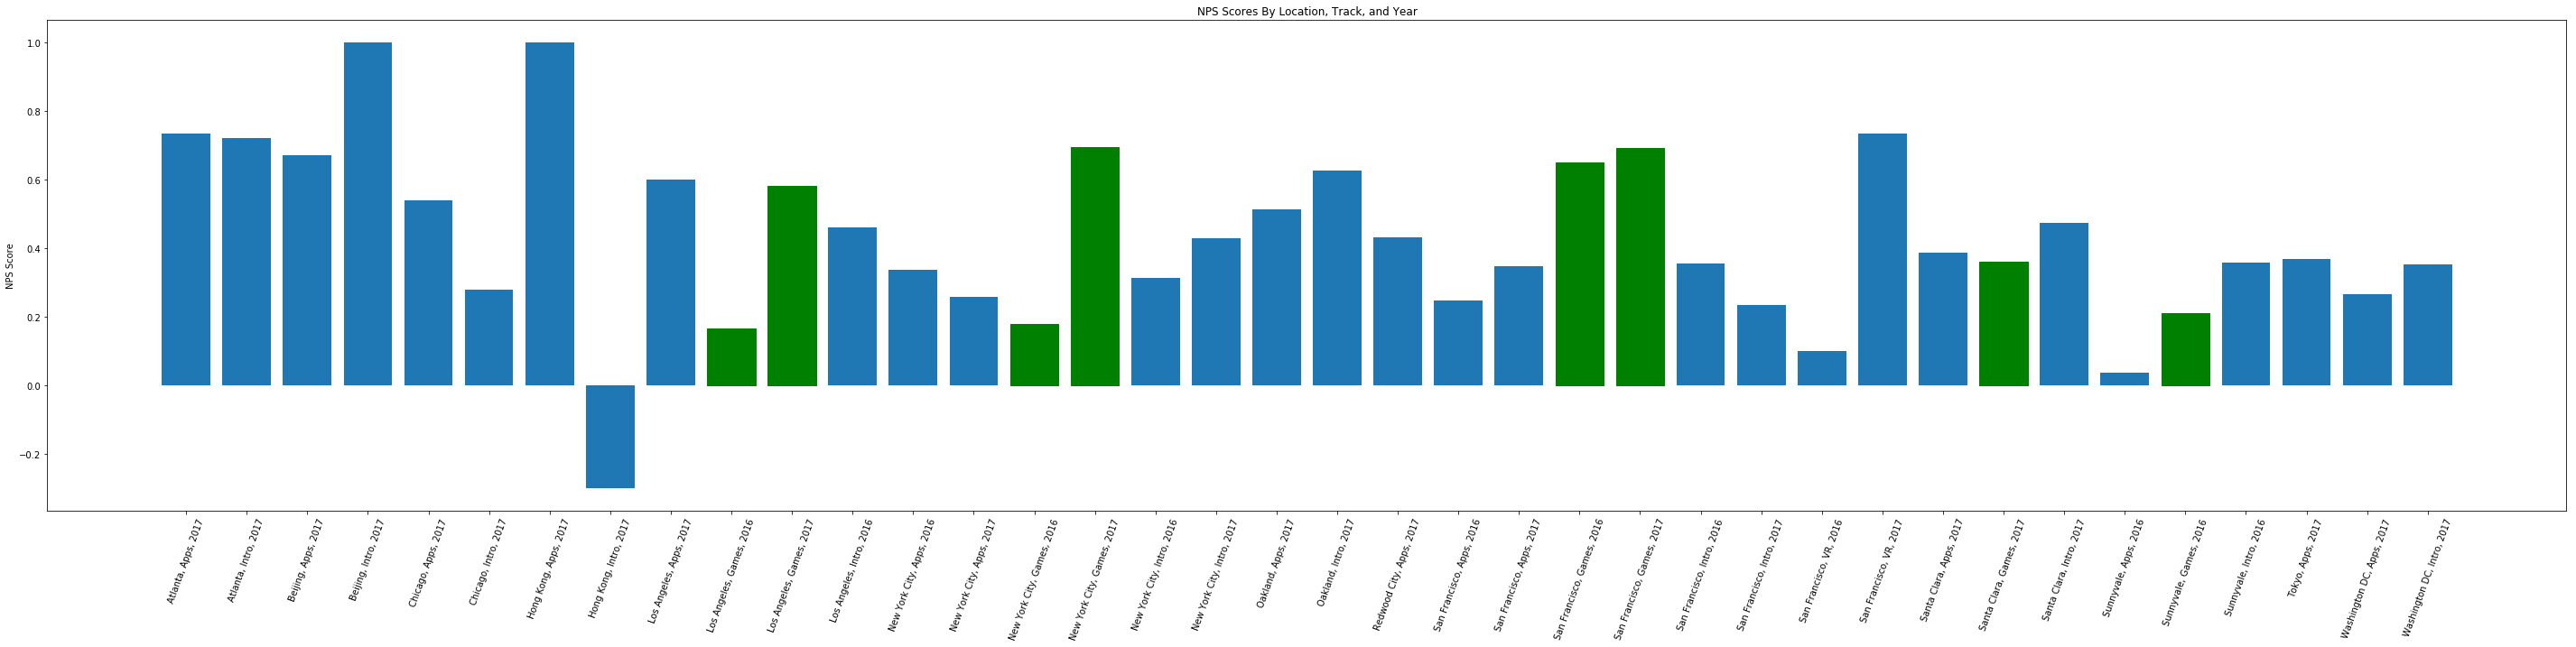

In [171]:
for city in cities:
    for track in tracks:
        for year in years:
            nps = alt_nps_by_city_track_and_year(city, track, year)
            nps_scores[(city, track, year)] = nps
            
# print(nps_scores)

# nps_list = sorted(nps_scores)
# print(nps_list)

y_values = []
x_values = []
games_indeces = []
for item in nps_scores.keys():
    if (nps_scores[item] == None):
        continue
    else:
        label = str(item[0]) + ", " + str(item[1]) + ", " + str(item[2])
        y_values.append(label)
        if(item[1] == "Games"):
            games_indeces.append(y_values.index(label))
        x_values.append(nps_scores[item])


# Now, let's graph all of that.
fig = plt.figure(figsize=(50, 10))
# fig.suptitle('NPS Score by Track and Year', fontsize=14, fontweight='bold')
 
barlist = plt.bar(y_values, x_values)
for index in games_indeces:
    barlist[index].set_color('g')
plt.xticks(rotation=70)
plt.ylabel('NPS Score')
plt.title('NPS Scores By Location, Track, and Year')

plt.savefig("alt_nps.png")
 
plt.show()